In [10]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import csv
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import pandas as pd
from PIL import Image
from torchvision import transforms
import torch
import torchvision.models as models
import torch.optim as optim
from torchvision import datasets

In [11]:
# Load the Pre-Trained ResNet Model
resnet_cnn = models.resnet18(weights=models.ResNet18_Weights)
resnet_cnn.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [12]:
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [13]:
class ReadDataCSV(Dataset):
    def __init__(self, csv_file_path, train=True, transform=None):
        data = pd.read_csv(csv_file_path)

        # Raw data extracted from csv file
        raw = data.to_numpy
        # Get the number of images in the CSV file
        num_images = data.shape[0]
        # All images stored as an array of pixels
        image_as_array = data.values[:,1:]
        # Labels from 1-18. One for each class. Each class represents a different family of fish.
        label_as_array = data.values[:,0]
        # Reshape the row of pixels into a 150x150x3 RGB image
        self.images_numpy = image_as_array.reshape(num_images, 150, 150, 3)


        self.targets = label_as_array
        self.transform = transform
    
    def __len__(self):
        return len(self.targets)

    def __getitem__(self, index):
        # Get the specific image and label from the array
        img, target = self.images_numpy[index], self.targets[index]
        img = img.squeeze().astype(np.uint8)
        img = Image.fromarray(img)

        # Perform the image transformation (nromalization)
        if self.transform is not None:
            img = self.transform(img)
        # Conver the target label into a tensor
        target = torch.tensor(target)
        return img, target

In [14]:
dataset = ReadDataCSV("test_data.csv",transform=img_transform)
batch_size = 256
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


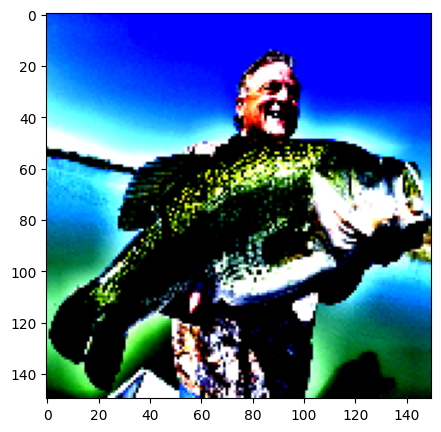

In [15]:
# Display an image from the training dataset to show that we are getting what we expect
[imgs,labels] = (next(iter(dataloader)))
imgs = np.squeeze(imgs)
plt.figure(figsize=(5,5))
plt.imshow(imgs[0].permute(1,2,0).cpu().numpy())

In [16]:
train_dataset = ReadDataCSV("train_data.csv",transform=img_transform)
test_dataset = ReadDataCSV("test_data.csv",transform=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size,shuffle=False)

In [17]:
CUDA=torch.cuda.is_available()

# Define the resnet-18 model
model = models.resnet18(weights=models.ResNet18_Weights)
num_ftrs = model.fc.in_features
# Perform linear transformation
model.fc = torch.nn.Linear(num_ftrs, 290)

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
accuracy_values=[]
epoch_number=[]
# Check if GPU is available
if CUDA:
    model.cuda()

# Train the ResNet-18 CNN using our test database
for epoch in range(25):  # loop over the dataset multiple times. Here 25 means 25 epochs
    running_loss = 0.0
    for i, (inputs,labels) in enumerate(train_dataloader, 0):
        if CUDA:
            inputs = inputs.cuda()
            labels = labels.cuda()
        else:
            inputs = inputs.cpu()
            labels = labels.cpu()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[epoch%d, itr%5d] loss: %.3f' %
                (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

    correct = 0
    total = 0
    
    # Test the ResNet-18 CNN model on our training database
    with torch.no_grad():
        for images, labels in test_dataloader:
            if CUDA:
                images = images.cuda()
                labels = labels.cuda()
            else:
                images = images.cpu()
                labels =labels.cpu()

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            if CUDA:
              correct += (predicted.cpu()==labels.cpu()).sum().item()
            else:
              correct += (predicted==labels).sum().item()

        TestAccuracy = 100 * correct / total
        epoch_number += [epoch+1]
        accuracy_values += [TestAccuracy]
        # Print the test accuracy per epoch
        print('Epoch=%d Test Accuracy=%.3f' %
                  (epoch + 1, TestAccuracy))

print('Finished Training')
torch.cuda.empty_cache()

c:\Users\seanc\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch=1 Test Accuracy=5.556
Epoch=2 Test Accuracy=42.424
Epoch=3 Test Accuracy=67.172
Epoch=4 Test Accuracy=71.212
Epoch=5 Test Accuracy=74.242
Epoch=6 Test Accuracy=76.263
Epoch=7 Test Accuracy=79.293
Epoch=8 Test Accuracy=81.313
Epoch=9 Test Accuracy=81.818
Epoch=10 Test Accuracy=82.323
Epoch=11 Test Accuracy=82.828
Epoch=12 Test Accuracy=82.828
Epoch=13 Test Accuracy=82.323
Epoch=14 Test Accuracy=82.323
Epoch=15 Test Accuracy=82.828
Epoch=16 Test Accuracy=82.828
Epoch=17 Test Accuracy=82.828
Epoch=18 Test Accuracy=82.828
Epoch=19 Test Accuracy=83.333
Epoch=20 Test Accuracy=83.333
Epoch=21 Test Accuracy=83.333
Epoch=22 Test Accuracy=83.333
Epoch=23 Test Accuracy=83.838
Epoch=24 Test Accuracy=83.838
Epoch=25 Test Accuracy=83.838
Finished Training


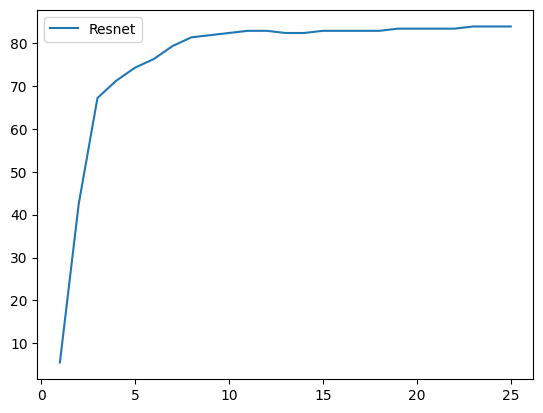

In [18]:
import matplotlib.pyplot as plt


plt.plot(epoch_number, accuracy_values, label="Resnet")

# Add a legend
plt.legend()

# Show the plot
plt.show()